In [12]:
def print_aln(alignment):
    for rec in alignment:
        print(rec.seq)

In [17]:
from Bio.AlignIO import read as read_aln
from Bio.Alphabet import generic_protein, generic_dna
# from Bio.Phylo import read as read_tre

aln = read_aln('seq/refs.hmmalign.refine.afa', 'fasta', alphabet=generic_protein)
aln_codons = read_aln('seq/refs.hmmalign.')
short = aln[0:10,0:90]
print_aln(short)

---NDKKLFLKALK-NKFN---EDPNEHYT-DYYCYGGWEQSPRKKEFNEFSKKLEE--ERGLPGYNPD---I---G-VPLGQRKLMSYK
----AEKMFIDALK-KAFK---EDPTDDKT-TFYNKGGWKQSERKREFVAAGKDIAA--KRGIPMYDPD---V---G-TPLGQRVLMPYQ
----AEKMFIEALK-KAFK---EDPTEKTT-EYYKFGGWKQSERKREFVAAGKEVAA--KRGIPQYDPD---V---G-TPLGQRVLMPYN
---NEKKLFLKALQ-SKFD---EDPKENHT-NFYCYGGWKQSPRKREFDEYAKKIEE--KRGIPFYNPD---I---G-VPLGQRKLMAYK
----AEKMFIDALK-KAFK---EDPTEGKT-TFYNHGGWKQSERKREFVAAGKEVAA--KRGIPQYNPD---V---G-TPLGQRVLMPYQ
----ADKKFIDALN-KKFK---EDPEEKKT-TFYSFGGWKQSERKREFVEAGKKIAA--ERGIPQYNPD---V---G-TPLGQRVLMPYQ
----ADKKFMEALK-KKFE---EAPEESKT-HFYDLGGWKQSERKTEFVKAGKEIAE--KRGIPMYNPD---V---G-TPLGQRVLMPYQ
----EKKLFAKALK-GKFD---EDPNENHT-NFYCFGGWEQSARKKEFNAEAEKLME-ERGGVPFYNPD---I---G-VPLGQRKLMAYK
----AEKMFINALK-KAFK---EDPSDKTT-EYFKFGGWKQSERKREFVEAGKEVAA--KRGIPQYDPD---V---G-TPLGQRVLMPYQ
---NEKKLFLKALQ-SKFD---EDPKQNHT-NFYCFGGWKQSPRKKEFDEYAKKIEE--QRGIPFYNPD---I---G-VPLGQRKLMAYK


In [82]:
from Bio.Alphabet.IUPAC import ExtendedIUPACProtein
from collections import Counter

def entropy(string):
    counts = np.asarray(list(Counter(string).values()))
    pk = counts / np.sum(counts)
    return -np.sum(pk * np.log(pk))

def aln_entropy(alignment):
    length = len(alignment[0])
    out = np.empty(length)
    for i in range(length):
        out[i] = entropy(alignment[:,i])
    return out
        
aln_entropy(short)

array([-0.        , -0.        , -0.        ,  0.6108643 ,  0.89794572,
        1.05492017, -0.        ,  1.05492017, -0.        ,  1.16828245,
        1.27985423, -0.        , -0.        ,  0.80181855, -0.        ,
        1.08889998,  0.67301167, -0.        ,  1.16828245, -0.        ,
       -0.        , -0.        , -0.        ,  0.32508297, -0.        ,
        1.5571131 ,  0.80181855,  1.64341772,  1.27985423, -0.        ,
       -0.        ,  1.50478828,  0.6108643 ,  0.32508297,  1.47080848,
        1.3592367 , -0.        , -0.        , -0.        ,  0.50040242,
       -0.        , -0.        ,  0.89794572, -0.        , -0.        ,
        0.89794572, -0.        , -0.        ,  0.95027054,  0.94334839,
        1.08889998,  0.89794572,  0.32508297,  0.94334839,  1.02965301,
        0.89794572,  0.69314718, -0.        ,  0.32508297,  1.08889998,
        0.32508297, -0.        ,  0.63903186, -0.        ,  1.27985423,
       -0.        ,  0.6108643 , -0.        , -0.        , -0.  

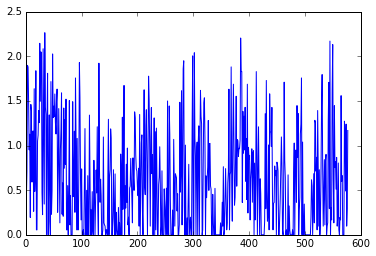

In [86]:
from matplotlib import pyplot as plt

plt.plot(aln_entropy(aln))

In [95]:
def moving_window(x, size, f=np.mean):
    x = np.asarray(x)
    out = np.empty(len(x))
    for i in range(len(x)):
        start = i
        stop  = min(len(x), i + size)
        out[i] = f(x[start:stop])
    return out

def smooth(x, bw):
    return moving_window(x, bw)

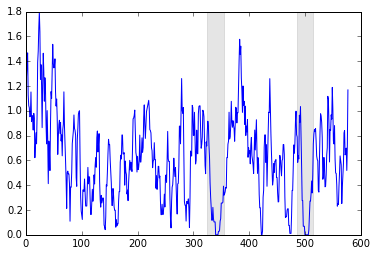

In [203]:
ax = plt.subplot(111)
ax.plot(smooth(aln_entropy(aln), 5))
ax.axvspan(325, 355, color='k', alpha=0.1)
ax.axvspan(485, 515, color='k', alpha=0.1)

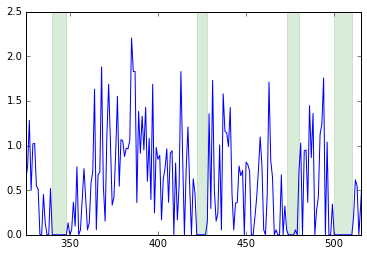

In [227]:
trace = aln_entropy(aln)

ax = plt.subplot(111)
ax.plot(trace)
ax.set_xlim(325, 515)
ax.axvspan(340, 348, color='g', alpha=0.15)  # Perfect AA conservation
ax.axvspan(422, 428, color='g', alpha=0.15)  # Perfect, but short (maybe 1 more 5' base)
ax.axvspan(473, 480, color='g', alpha=0.15)  # Imperfect and short
ax.axvspan(500, 510, color='g', alpha=0.15)  # Perfect AA conservation

In [244]:
Counter.most_common?

In [249]:
trace[473:480]

array([ 0.05554608, -0.        , -0.        , -0.        , -0.        ,
        0.05554608, -0.        ])

In [250]:
from collections import Counter

def consensus(alignment):
    out = []
    for i in range(len(alignment[0])):
        out.append(Counter(alignment[:,i]).most_common(1)[0][0])
    return "".join(out)

def profile(alignment, letters):
    out = np.empty(len(alignment[0]))

m1 = consensus(aln[:,340:348])
m2 = consensus(aln[:,422:428])
m3 = consensus(aln[:,473:480])
m4 = consensus(aln[:,500:510])
print(m1, m2, m3, m4)

YMSGGVGF FGGSQR DLQDQCG NYPNYAMNVG


In [231]:
reverse_translation_table = \
{'F': 'TTY',
 'L': 'YTN',
 'I': 'ATH',
 'M': 'ATG',
 'V': 'GTN',
 'S': 'WSN',
 'P': 'CCN',
 'T': 'ACN',
 'A': 'GCN',
 'Y': 'TAY',
 'H': 'CAY',
 'Q': 'CAR',
 'N': 'AAY',
 'K': 'AAR',
 'D': 'GAY',
 'E': 'GAR',
 'C': 'TGY',
 'W': 'TGG',
 'R': 'MGN',
 'G': 'GGN',
}

def back_translate(prot_seq):
    out = []
    for res in prot_seq:
        out.append(reverse_translation_table[res])
    return "".join(out)

back_translate("FLIMVSPTAYHQNKDECWRG")
# TTYYTNATHATGGTNWSNCCNACNGCNTAYCAYCARAAYAARGAYGARTGYTGGMGNGGN

'TTYYTNATHATGGTNWSNCCNACNGCNTAYCAYCARAAYAARGAYGARTGYTGGMGNGGN'

In [251]:
for motif in (m1, m2, m3, m4):
    seq = Seq(back_translate(motif), alphabet=IUPAC.ambiguous_dna)
    print("{}\t{}".format(seq, seq.reverse_complement()))

TAYATGWSNGGNGGNGTNGGNTTY	RAANCCNACNCCNCCNSWCATRTA
TTYGGNGGNWSNCARMGN	NCKYTGNSWNCCNCCRAA
GAYYTNCARGAYCARTGYGGN	NCCRCAYTGRTCYTGNARRTC
AAYTAYCCNAAYTAYGCNATGAAYGTNGGN	NCCNACRTTCATNGCRTARTTNGGRTARTT
